#### ANL Sprint 2017

HSC-DR1 LSS Sprint:

Example use of some of the code (e.g. dataCleanUp, plotDiagnostics) on a forced catalog and corresponding random catalog from HSC-DR1.

Also, create some of the systematics maps listed in ISSUE#3 here: https://github.com/LSSTDESC/HyperSupremeStructure-HSC-LSS/issues/3. 

Using the flatmap object to pixelize maps, without using HEALPix.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import os
from astropy.io import fits

from astropy.table import Table
from matplotlib import cm
import copy

from dataCleanUp import dataCleanUp
from plots import plotDiagnostics
from createMaps import createCountsMap, createMeanStdMaps

Read in the data.

In [2]:
HSCdatapath= '/global/cscratch1/sd/damonge/HSC/'
HSCFiles= os.listdir(HSCdatapath)
HSCFiles= ['HSC_WIDE_GAMA15H_forced.fits', 'HSC_WIDE_GAMA15H_random.fits']

In [3]:
HSCFiles= [HSCdatapath+f for f in HSCFiles]
HSCFiles

['/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_forced.fits',
 '/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_random.fits']

In [4]:
HSCdata= {}
for filename in HSCFiles:
    key= filename.split('WIDE_')[1].split('.fits')[0]
    dat = Table.read(filename, format='fits')
    HSCdata[key] = dat.to_pandas()
    
HSCFieldTag= key.split('_')[0]  # just the field tag.

Data clean up

In [5]:
for key in HSCdata:
    print key
    HSCdata[key]= dataCleanUp(HSCdata[key])

GAMA15H_random
Given size of the dataframe:  (8121501, 60)
Dropped 30 isnull columns.
Dropped 8121471 rows since they contained nan entries.
idetect_is_primary in dataframe, so dropping objects with idetect_is_primary= False.
Dropped 2022870 rows based on idetect_is_primary= False.
Final size of the dataframe:  (6098631, 29)

GAMA15H_forced
Given size of the dataframe:  (7681225, 196)
Dropped 98 isnull columns.
Dropped 7681127 rows since they contained nan entries.
Final size of the dataframe:  (6139128, 98)



Plot diagnostics

*************************
GAMA15H_random
Plotting ra, dec plot.


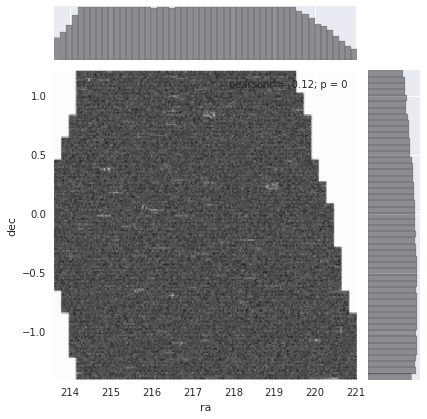

Plotting cmodel_mag distributions.
Not plotting cmodel_mag since dont have the needed columns:
['gcmodel_mag', 'rcmodel_mag', 'icmodel_mag', 'zcmodel_mag', 'ycmodel_mag'].

Plotting cmodel_mag_err distributions.
Not plotting cmodel_mag_err since dont have the needed columns:
['gcmodel_mag_err', 'rcmodel_mag_err', 'icmodel_mag_err', 'zcmodel_mag_err', 'ycmodel_mag_err'].

Plotting absorption distributions.
Not plotting absorption since dont have the needed columns:
['a_g', 'a_r', 'a_i', 'a_z', 'a_y'].

Plotting countinputs distributions.


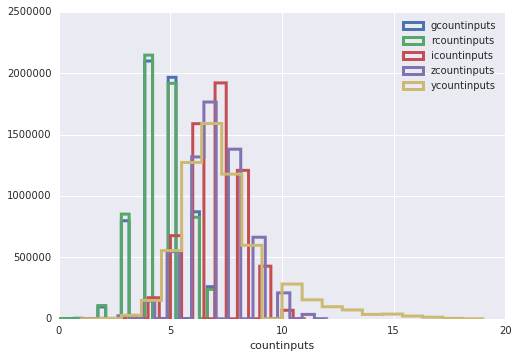

*************************
GAMA15H_forced
Plotting ra, dec plot.


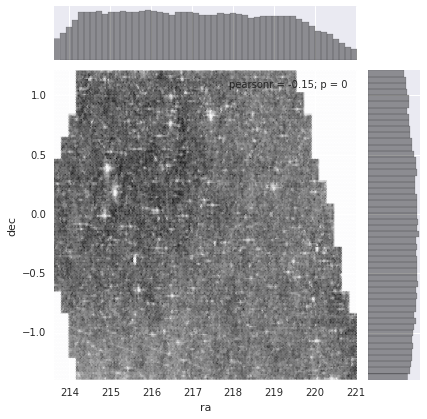

Plotting cmodel_mag distributions.


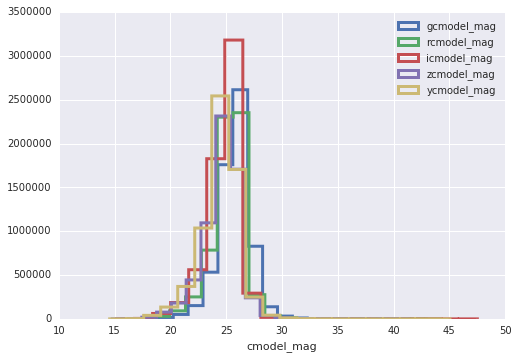

Plotting cmodel_mag_err distributions.


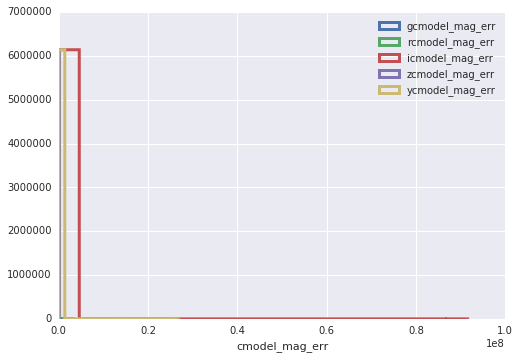

Plotting absorption distributions.


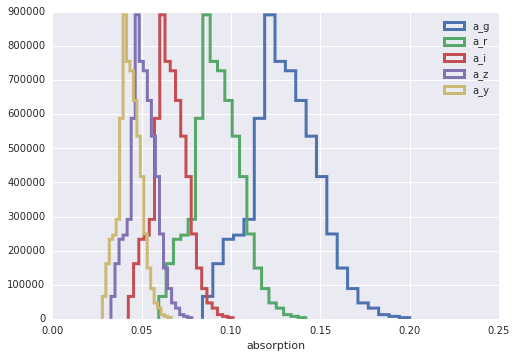

Plotting countinputs distributions.


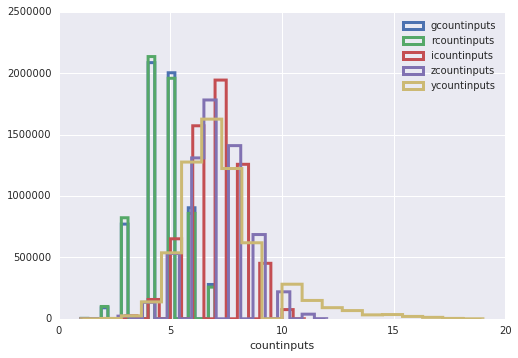

In [6]:
for key in HSCdata:
    print '*************************'
    print key
    plotDiagnostics(HSCdata[key])

Create some maps using the flatmaps object.

In [7]:
import flatmaps as fm
flatSkyGrid= fm.FlatMapInfo([212.5,222.],[-2.,2.], dx=0.057,dy=0.057) # eventually would generalize to automate with 
                                                                      # params based on the data itself.

In [8]:
HSCDataKey= 'GAMA15H_forced'
bands= ['g', 'r', 'i', 'z', 'y']

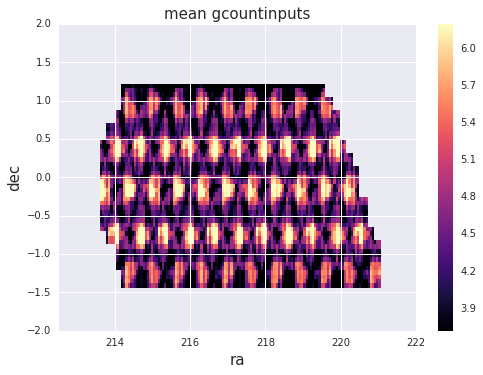

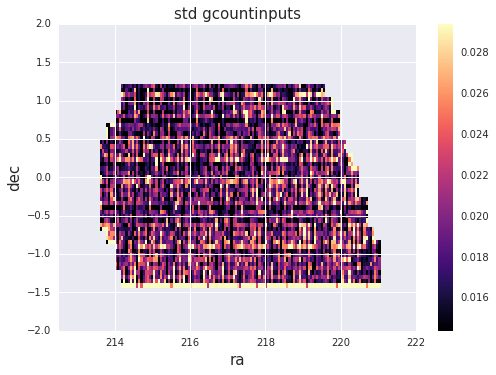

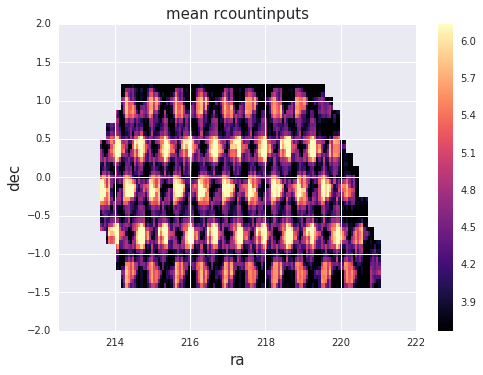

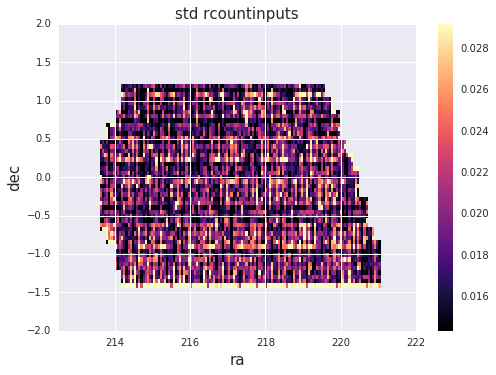

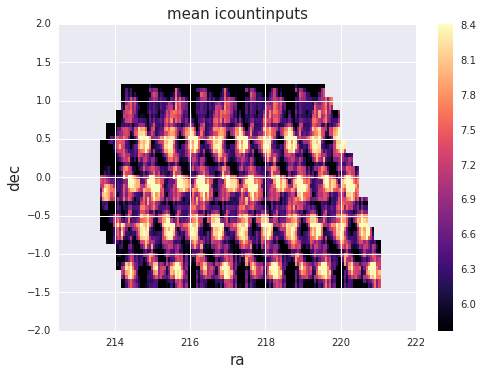

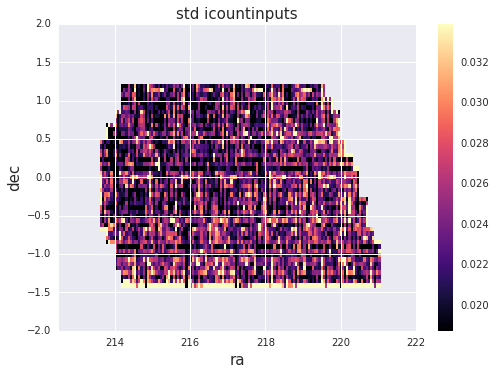

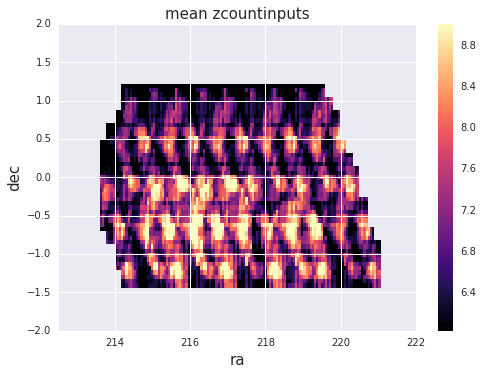

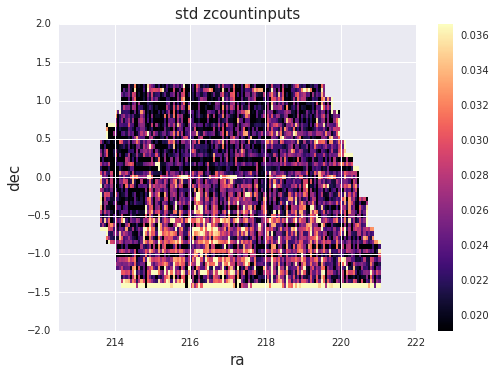

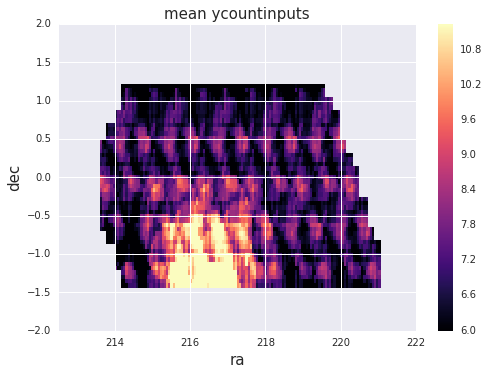

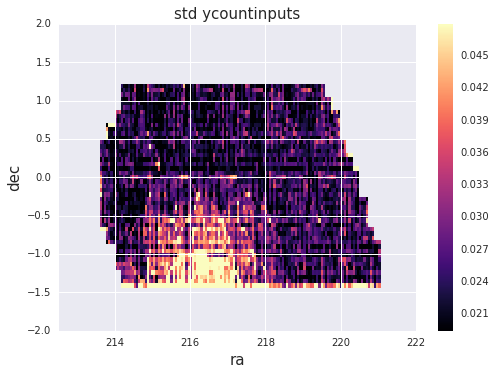

In [9]:
# Xcountinputs: number of images contributing to each object
for band in bands:
    colKey= '%scountinputs'%band
    createMeanStdMaps(ra= HSCdata[HSCDataKey]['ra'],
                      dec= HSCdata[HSCDataKey]['dec'], 
                      quantity= HSCdata[HSCDataKey][colKey],
                      flatSkyGrid= flatSkyGrid, returnMaps= False,
                      plotMaps= True, quantityName= colKey)

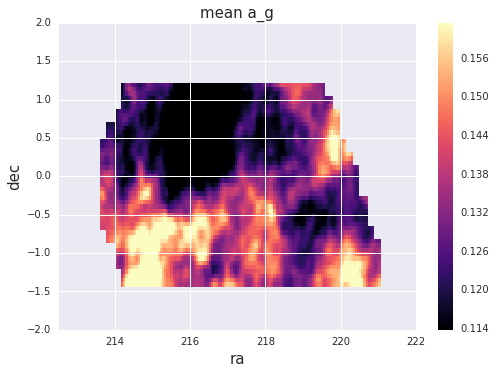

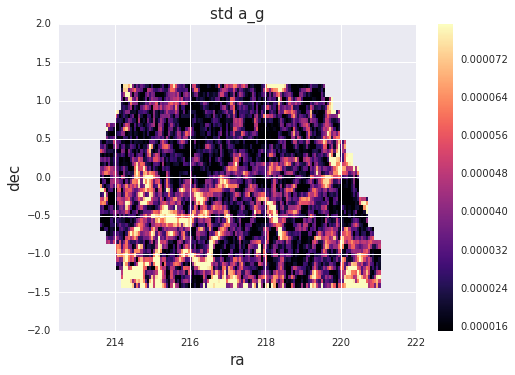

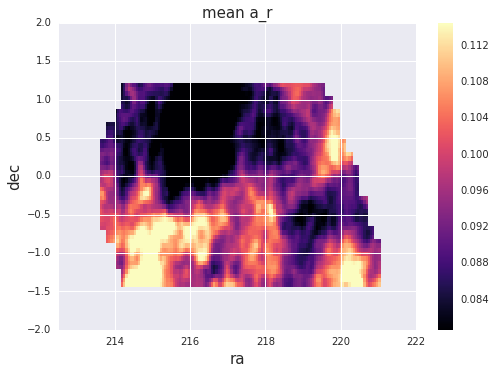

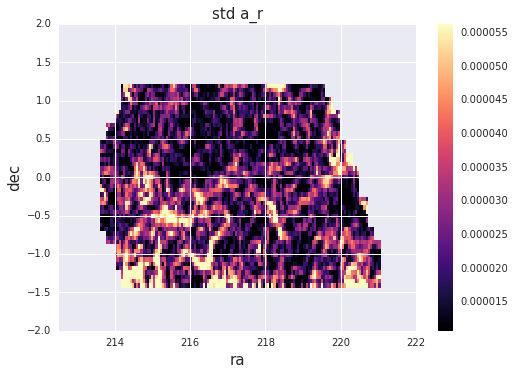

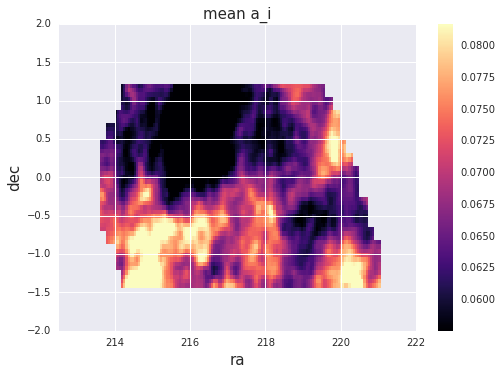

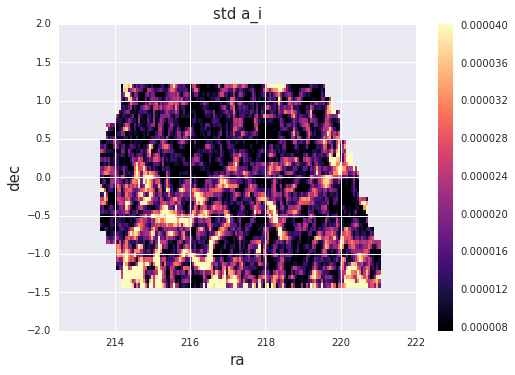

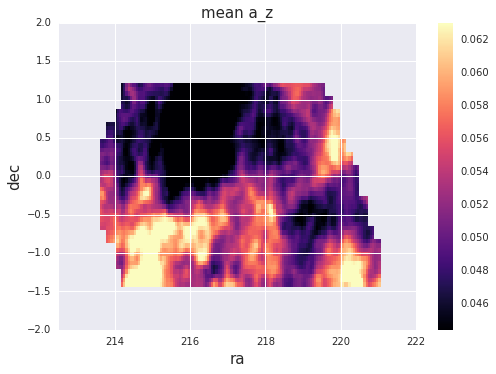

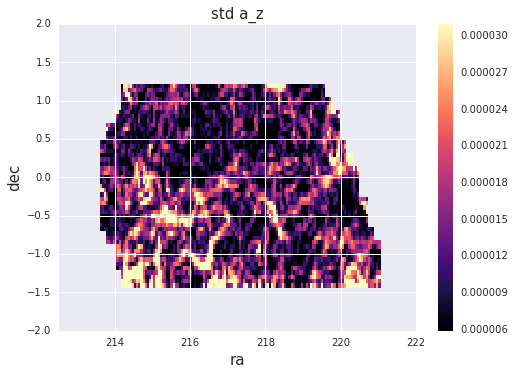

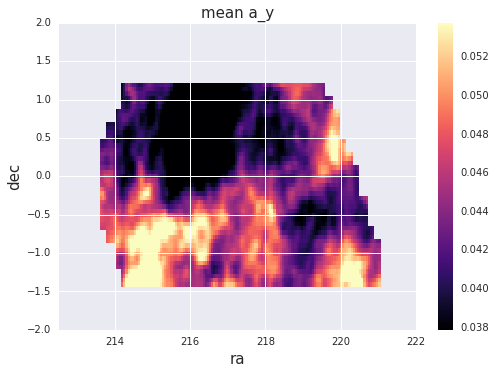

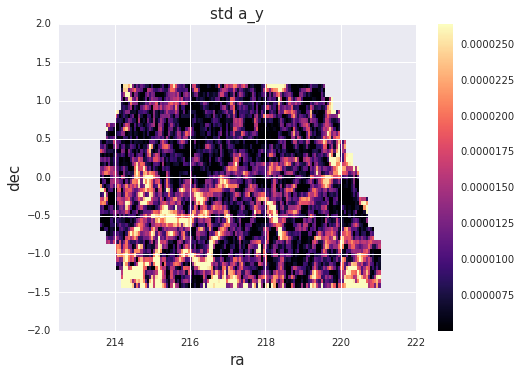

In [10]:
# Dust extinction
for band in bands:
    colKey= 'a_%s'%band
    createMeanStdMaps(ra= HSCdata[HSCDataKey]['ra'],
                      dec= HSCdata[HSCDataKey]['dec'],
                      quantity= HSCdata[HSCDataKey][colKey],
                      flatSkyGrid= flatSkyGrid, returnMaps= False,
                      plotMaps= True, quantityName= colKey)

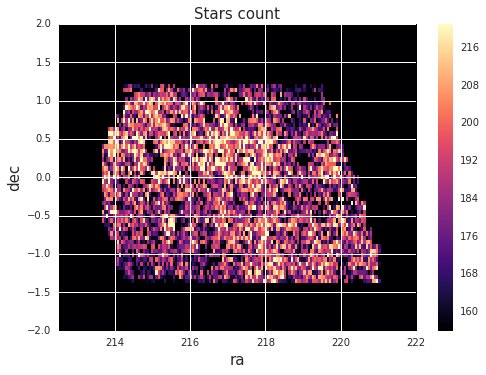

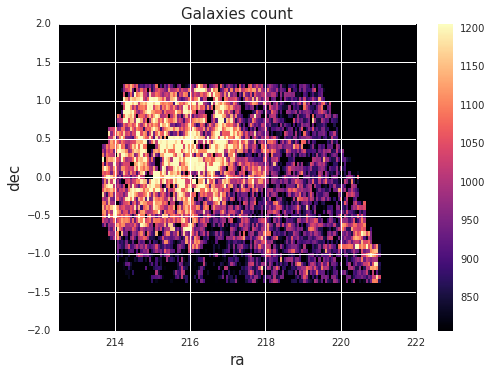

In [11]:
# Star count map (from iclassification_extendedness= 0)
ind= np.where(HSCdata[HSCDataKey]['iclassification_extendedness']==0)[0]
createCountsMap(ra= HSCdata[HSCDataKey].iloc[ind]['ra'],
                dec= HSCdata[HSCDataKey].iloc[ind]['dec'],
                flatSkyGrid= flatSkyGrid, returnMap= False,
                plotMap= True, quantityName= 'Stars')

# Galaxy count map (from iclassification_extendedness= 1)
ind= np.where(HSCdata[HSCDataKey]['iclassification_extendedness']==1)[0]
createCountsMap(ra= HSCdata[HSCDataKey].iloc[ind]['ra'],
                dec= HSCdata[HSCDataKey].iloc[ind]['dec'], 
                flatSkyGrid= flatSkyGrid, returnMap= False,
                plotMap= True, quantityName= 'Galaxies')

In [12]:
keys= HSCdata.keys()

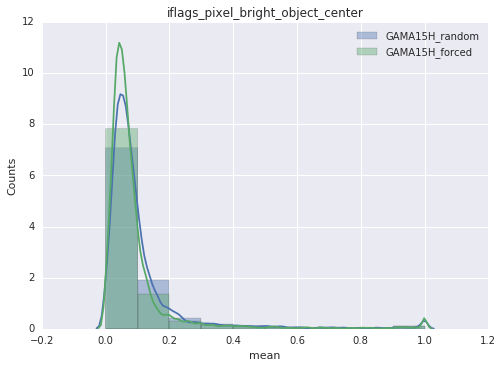

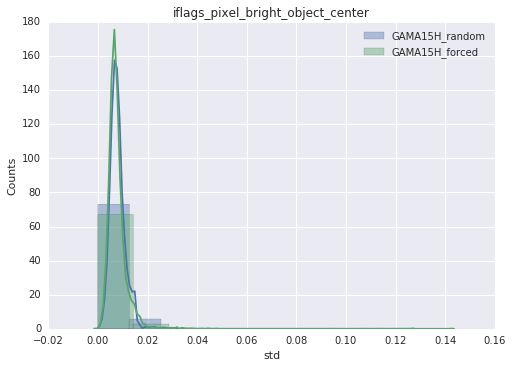

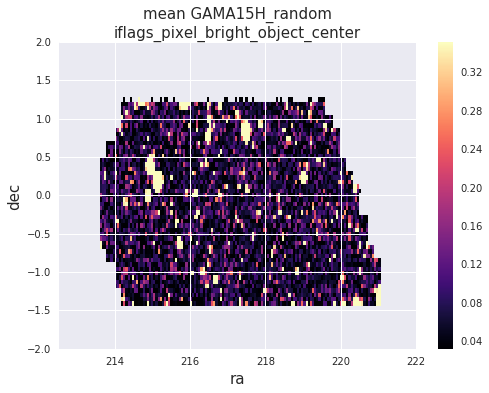

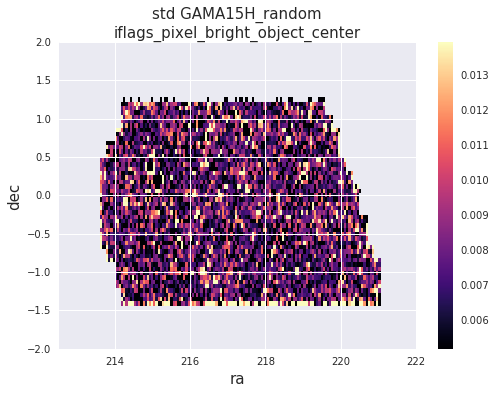

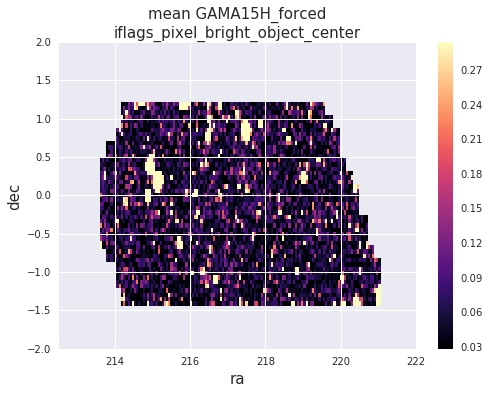

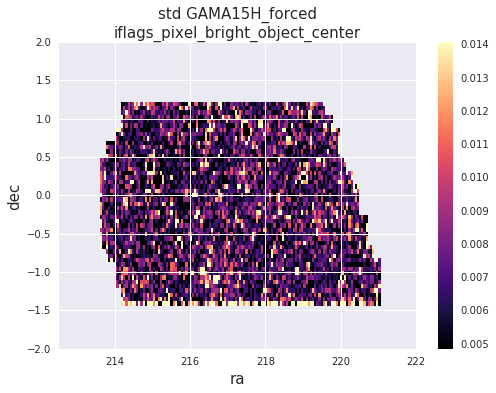

In [13]:
# plot iflags_pixel_bright_object_center. compare between those in forced vs. random tables.
colKey= 'iflags_pixel_bright_object_center'

fig, ax1= plt.subplots(1,1)
fig, ax2= plt.subplots(1,1)

axes= [ax1, ax2]

for key in keys:
    mean, std= createMeanStdMaps(ra= HSCdata[key]['ra'],
                                           dec= HSCdata[key]['dec'],
                                           quantity= HSCdata[key][colKey],
                                           flatSkyGrid= flatSkyGrid, returnMaps= True,
                                           plotMaps= True, quantityName= '%s\n%s'%(key, colKey))
    sns.distplot(mean[~np.isnan(mean)], ax= axes[0], label= key, bins= 10)
    sns.distplot(std[~np.isnan(std)], ax= axes[1], label= key, bins= 10)

for ax in axes:
    ax.set_title(colKey)
    ax.legend()
    ax.set_ylabel('Counts')
axes[0].set_xlabel('mean')
axes[1].set_xlabel('std')

plt.show()

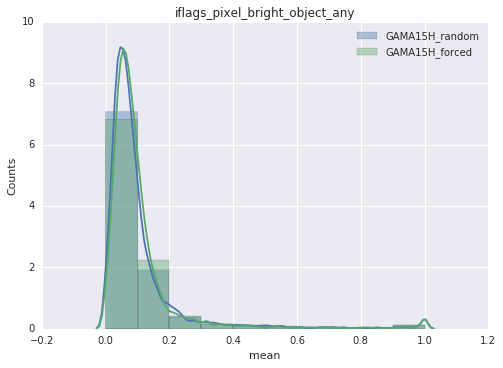

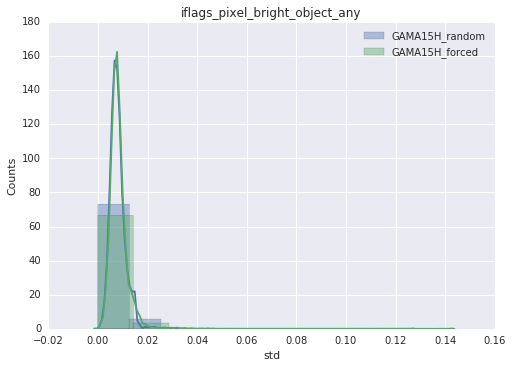

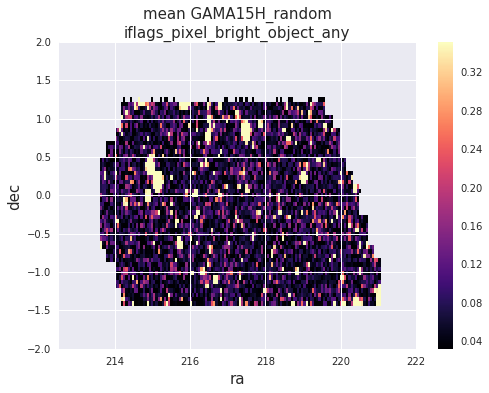

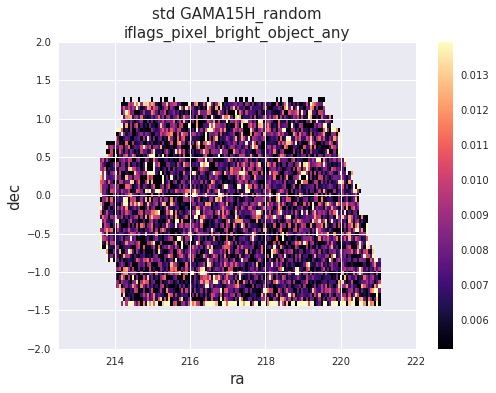

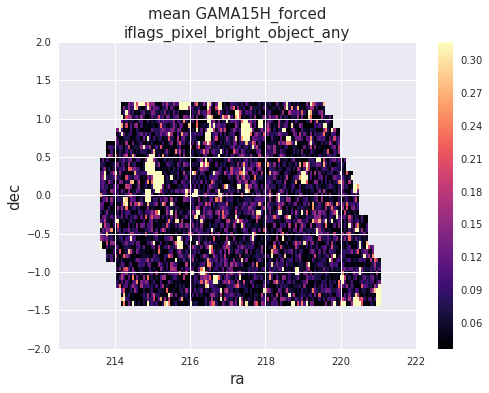

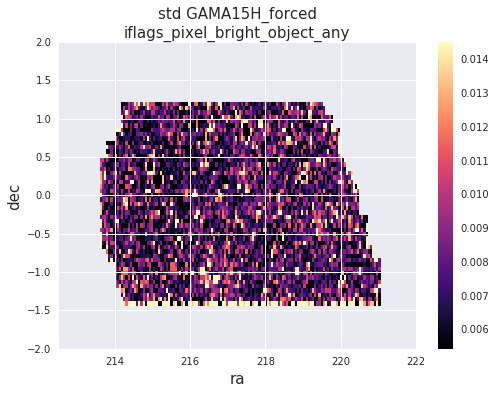

In [14]:
# plot iflags_pixel_bright_object_any. compare between those in forced vs. random tables.
colKey= 'iflags_pixel_bright_object_any'

fig, ax1= plt.subplots(1,1)
fig, ax2= plt.subplots(1,1)

axes= [ax1, ax2]

for key in keys:
    mean, std= createMeanStdMaps(ra= HSCdata[key]['ra'],
                                           dec= HSCdata[key]['dec'],
                                           quantity= HSCdata[key][colKey],
                                           flatSkyGrid= flatSkyGrid, returnMaps= True,
                                           plotMaps= True, quantityName= '%s\n%s'%(key, colKey))
    sns.distplot(mean[~np.isnan(mean)], ax= axes[0], label= key, bins= 10)
    sns.distplot(std[~np.isnan(std)], ax= axes[1], label= key, bins= 10)

for ax in axes:
    ax.set_title(colKey)
    ax.legend()
    ax.set_ylabel('Counts')
axes[0].set_xlabel('mean')
axes[1].set_xlabel('std')

plt.show()    

Ok so the maps for iflags_pixel_bright_object_any and iflags_pixel_bright_object_center from forced and random catalogs dont match. why? quite unclear.

Note that the flags are boolen and maps are not -- maybe calculating mean/std on 0,1 flags is the issue?